This notebook will be used to extract events positions from the statsbomb dataset
and use them as starting positions to evaluate a multiagent policy

The focus will be on shots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import sys

# List of required packages
required_packages = [
    "pandas", "numpy", "matplotlib", "seaborn", "networkx"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)


pandas is already installed.
numpy is already installed.
matplotlib is already installed.
seaborn is already installed.
networkx is already installed.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

from matplotlib.patches import Arc

In [4]:
install_package("statsbombpy")

statsbombpy is already installed.


In [5]:
from statsbombpy import sb

In [6]:
# Suppress the authentication warning
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter("ignore", NoAuthWarning)

In [7]:
# Load all competitions
comps = sb.competitions()

# Extract the numeric year from 'season_name' (e.g. "2023/2024" -> 2023)
comps['season_year'] = comps['season_name'].str[:4].astype(int)

# Sort competition ascending by'season_year'
comps_sorted = comps.sort_values(by='season_year', ascending=True).reset_index(drop=True)

all_matches_list = []
total_matches = 0

# Iterate over competitions in chronological order
for idx, row in comps_sorted.iterrows():
    cid = row['competition_id']
    sid = row['season_id']
    comp_name = row['competition_name']
    season_name = row['season_name']
    season_year = row['season_year']
    
    # Load matches for the competition + season
    comp_matches = sb.matches(competition_id=cid, season_id=sid)
    
    # Sort by match_date ascending
    comp_matches = comp_matches.sort_values(by='match_date', ascending=True)
    
    # Print matches in chronological order
    match_count = 0
    for m_idx, m_row in comp_matches.iterrows():
        match_date = m_row['match_date']
        home_team  = m_row['home_team']
        away_team  = m_row['away_team']
        home_score = m_row['home_score']
        away_score = m_row['away_score']
        
        # Print each match line: date, home vs away, final score
        match_count += 1

    # Print the total number of matches for this competition + season
    
    # Accumulate into an overall total and list
    total_matches += match_count
    all_matches_list.append(comp_matches)

# This will create a single DataFrame with all matches
all_matches = pd.concat(all_matches_list, ignore_index=True)

# Print the grand total of matches across all competitions/seasons
print("\n-------------------------------------------")
print(f"Grand total across all comps/seasons: {total_matches} matches")


-------------------------------------------
Grand total across all comps/seasons: 3464 matches


In [8]:
all_assists_list = []
i = 0

for match_id in all_matches['match_id']:
    # Fetch events for the current match
    events = sb.events(match_id=match_id)

    # Check if the column exists and filter for assists
    if 'pass_shot_assist' in events.columns:
        assists = events[events['pass_shot_assist'] == True].copy()
        
        if not assists.empty:
            i += 1
            # Add the match_id column so you know which match the assist belongs to
            assists['match_id'] = match_id
            
            # Append this match's assists to the list
            all_assists_list.append(assists)

    if i == 10: break

# Concatenate everything into one single DataFrame
if all_assists_list:
    final_assists_df = pd.concat(all_assists_list, ignore_index=True)
    print("--- Success! ---")
    print(f"Total assists collected: {len(final_assists_df)}")
else:
    print("No assists found in any of the matches.")
    final_assists_df = pd.DataFrame() # Return empty df to avoid errors later



--- Success! ---
Total assists collected: 286


In [9]:
final_assists_df.get('pass_end_location')

0      [106.3, 27.4]
1      [100.4, 39.7]
2      [105.2, 50.8]
3      [106.8, 29.5]
4      [109.6, 32.3]
           ...      
281    [105.6, 31.4]
282     [99.5, 42.5]
283    [104.4, 31.7]
284    [103.9, 28.6]
285     [65.1, 37.2]
Name: pass_end_location, Length: 286, dtype: object

In [10]:
final_assists_df.get('location')

0       [85.6, 11.1]
1      [115.4, 70.1]
2      [107.2, 66.5]
3      [100.1, 42.7]
4      [117.1, 24.1]
           ...      
281     [91.8, 39.6]
282     [89.9, 56.8]
283    [109.5, 39.1]
284    [106.8, 21.8]
285     [60.0, 40.0]
Name: location, Length: 286, dtype: object

## Simulation with custom positions

From the selected failed assists we select the start and end position to use them as the custom starting postions of the two attackers in the digital twin


=== MULTI-AGENT EVALUATION: WHAT_IF ===
Loading RLlib checkpoint: D:/PoliTo/Anno 5/DS project/footballAI-ads/src/football_tactical_ai/training/models/whatIFModel


d:\PoliTo\Anno 5\DS project\footballAI-ads\.venv\Lib\site-packages\gymnasium\envs\registration.py:642: UserWarning: WARN: Overriding environment rllib-multi-agent-env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
2026-01-31 16:18:35,444	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Total test cases: 1

→ Test case 1/1: what_if
   Attacker starts (m): [(115.4, 70.1), (100.4, 39.7)]


runs: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]

   → Trajectories saved to D:/PoliTo/Anno 5/DS project/footballAI-ads/src/football_tactical_ai/evaluation/results/logs/WhatIF\multi_traj_what_if.json

   === STATISTICS (AGGREGATED REWARDS) ===
   ATT_1 → mean: -0.054, std: 0.019, min: -0.060, max: 0.096
   ATT_2 → mean: -0.009, std: 0.001, min: -0.010, max: -0.006


=== FINAL SUMMARY ===
Results saved to: D:/PoliTo/Anno 5/DS project/footballAI-ads/src/football_tactical_ai/evaluation/results/logs/WhatIF\multi_evaluation.json



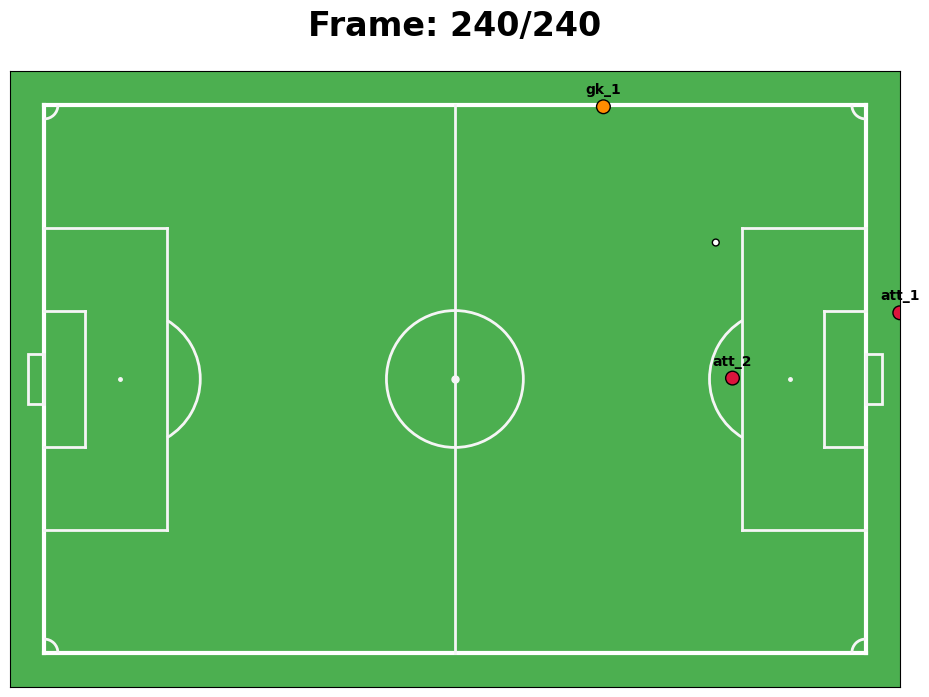

In [ ]:
from football_tactical_ai.evaluation.eval_what_if import evaluate_multi


a1 = final_assists_df.get('location')[1]
a2 = final_assists_df.get('pass_end_location')[1]

results = evaluate_multi(a1, a2, "what_if")

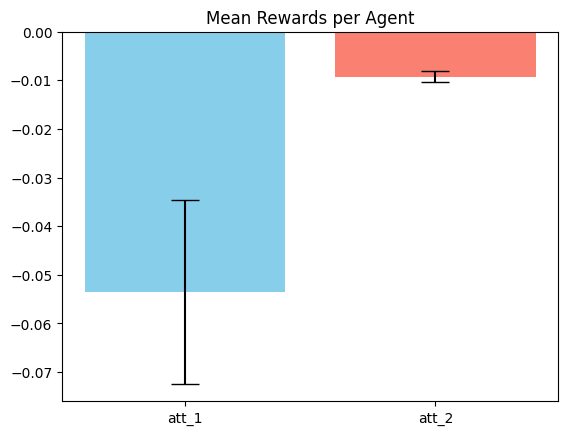

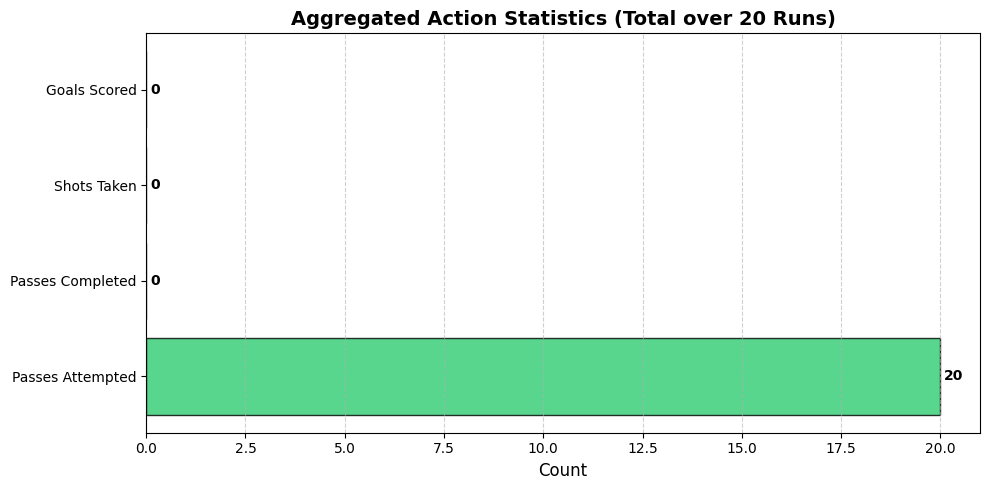

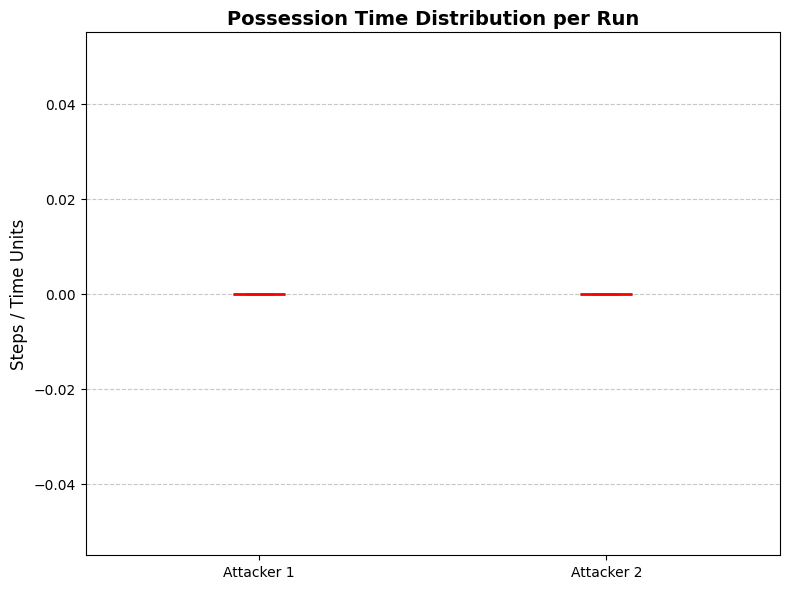

In [15]:
import json
import matplotlib.pyplot as plt

# Load data
with open('D:/PoliTo/Anno 5/DS project/footballAI-ads/src/football_tactical_ai/evaluation/results/logs/WhatIF/multi_evaluation.json', 'r') as f:
    data = json.load(f)['what_if']

# 1. Plot Rewards
agents = data["totals"]["agents"]
names = list(agents.keys())
means = [agents[n]["mean"] for n in names]
stds = [agents[n]["std"] for n in names]

plt.bar(names, means, yerr=stds, capsize=10, color=['skyblue', 'salmon'])
plt.title("Mean Rewards per Agent")
plt.show()


runs_data = data["runs"]
# 2. AGGREGATED ACTION STATISTICS
# Calculate totals across all runs
total_pass_att = sum(r["passing_stats"]["attempted_A1_to_A2"] + r["passing_stats"]["attempted_A2_to_A1"] for r in runs_data.values())
total_pass_comp = sum(r["passing_stats"]["completed_A1_to_A2"] + r["passing_stats"]["completed_A2_to_A1"] for r in runs_data.values())
total_shots = sum(r["shooting_stats"]["shots_A1"] + r["shooting_stats"]["shots_A2"] for r in runs_data.values())
total_goals = data["totals"]["episode_outcomes"]["episodes_with_goal"]

stats_labels = ['Passes Attempted', 'Passes Completed', 'Shots Taken', 'Goals Scored']
stats_values = [total_pass_att, total_pass_comp, total_shots, total_goals]

plt.figure(figsize=(10, 5))
plt.barh(stats_labels, stats_values, color='#2ecc71', edgecolor='black', alpha=0.8)
plt.title('Aggregated Action Statistics (Total over 20 Runs)', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add value labels to the end of each bar
for i, v in enumerate(stats_values):
    plt.text(v + 0.1, i, str(v), color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


# 3. POSSESSION DISTRIBUTION
# Extract lists of possession times for each agent across all runs
poss_A1 = [r["possession_stats"]["poss_time_A1"] for r in runs_data.values()]
poss_A2 = [r["possession_stats"]["poss_time_A2"] for r in runs_data.values()]

plt.figure(figsize=(8, 6))
plt.boxplot([poss_A1, poss_A2], labels=['Attacker 1', 'Attacker 2'], patch_artist=True,
            boxprops=dict(facecolor='#f1c40f', color='black', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))

plt.title('Possession Time Distribution per Run', fontsize=14, fontweight='bold')
plt.ylabel('Steps / Time Units', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()